In [1]:
import jax
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from jax import random

import liesel.experimental.optim as opt
import liesel.goose as gs
import liesel.model as lsl

In [2]:
key = random.PRNGKey(13)
key, key_beta, key_data = random.split(key, 3)

N = 1000
Q = 4

tau2_inv = 8.0

beta = tfd.Normal(loc=0.0, scale=jnp.sqrt(tau2_inv)).sample(
    sample_shape=(Q,), seed=key_beta
)

key_X, key_y = random.split(key_data, 2)

X = tfd.Uniform(0.0, 1.0).sample(sample_shape=(N, beta.shape[0] - 1), seed=key_X)

likelihood = tfd.Normal
y = likelihood(beta[0] + X @ beta[1:], 1.0).sample(seed=key_y)

Next, we create a train/validation/test split of the data.

In [3]:
beta

Array([-1.9520493, -6.7598357,  1.8330516,  3.140267 ], dtype=float32)

In [4]:
X

Array([[0.73391366, 0.99279845, 0.6151546 ],
       [0.47246027, 0.69206786, 0.97466433],
       [0.84575045, 0.20212555, 0.0699439 ],
       ...,
       [0.4034214 , 0.23944902, 0.931291  ],
       [0.83097506, 0.43323827, 0.9711492 ],
       [0.27072513, 0.7501899 , 0.22153962]], dtype=float32)

/Users/johannesbrachem/Documents/git/liesel/.venv/lib/python3.13/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 20'. Pick better value with 'binwidth'.


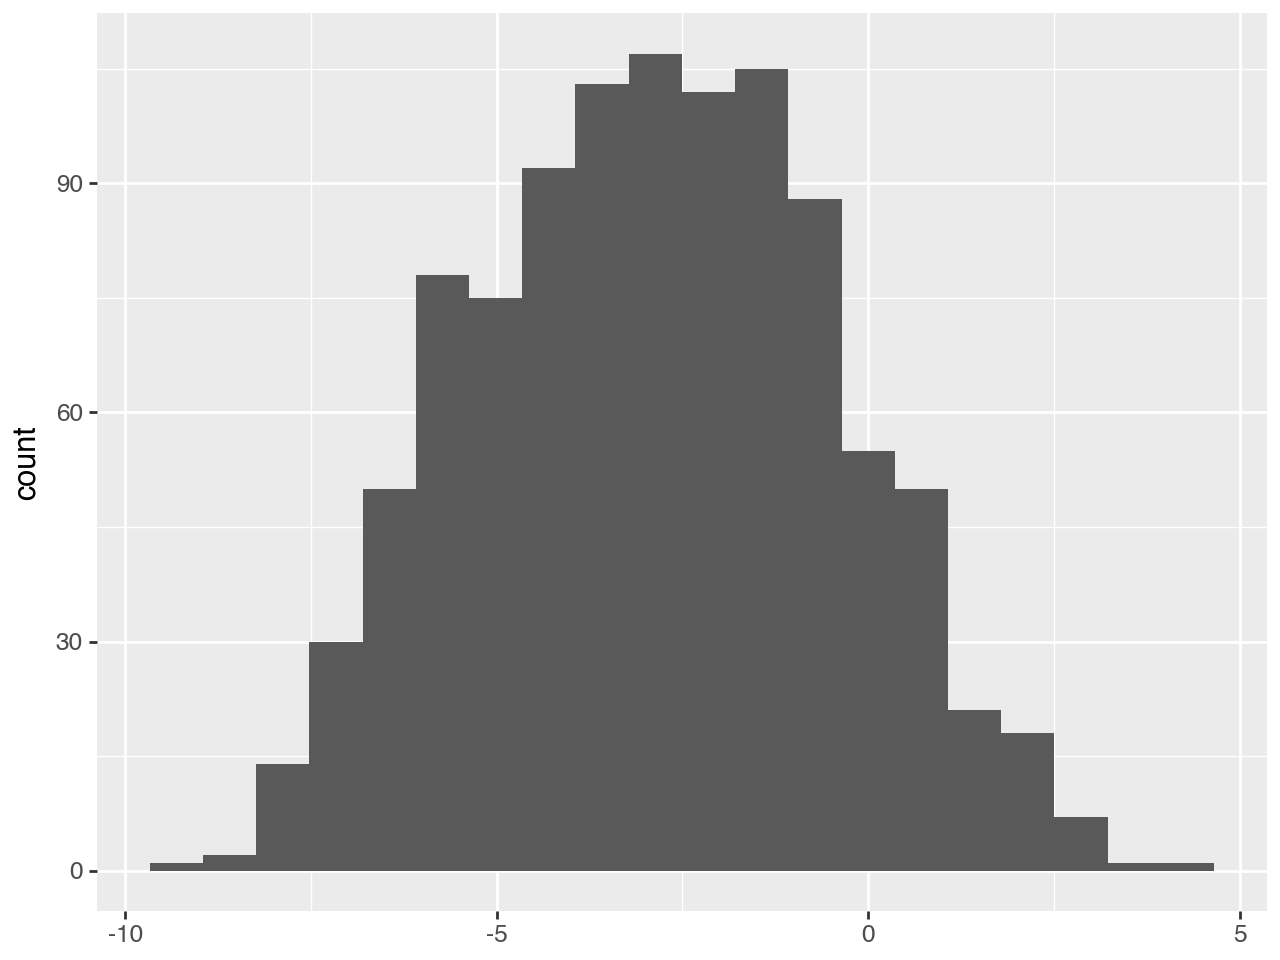

In [5]:
import plotnine as p9

p9.qplot(y, geom="histogram")

In [6]:
split = opt.Split.from_share(
    position_keys=["y", "X"],
    n=y.size,
    share_validate=0.1,
    share_test=0.0,
    axes=None,
    default_axis=0,
    shuffle=True,
    seed=1,
)

# Finally, we apply the split to the position
position = {"X": X, "y": y}
data = split.split_position(position)

Next, we prepare batching.

In [7]:
bi = opt.Batches(
    position_keys=["y", "X"],
    n=data.n_train,
    batch_size=32,
    shuffle=False,
    axes=None,
    default_axis=0,
)
initial_batch = bi.get_batched_position(data.train, batch_index=0)

In [8]:
X = lsl.Var.new_obs(value=X, name="X")

# loc

beta_loc_0 = lsl.Var.new_param(value=0.0, name="beta_loc_0")

beta_loc_dist = lsl.Dist(distribution=tfd.Normal, loc=0.0, scale=10.0)
beta_loc = lsl.Var.new_param(
    value=jnp.zeros(Q - 1), distribution=beta_loc_dist, name="beta_loc"
)

# variance

beta_scale_0 = lsl.Var.new_param(value=0.0, name="beta_scale_0")

eta_fn_loc = lambda X, beta_0, beta: beta_0 + X @ beta
eta_fn_scale = jnp.exp

loc = lsl.Var(lsl.Calc(eta_fn_loc, X, beta_loc_0, beta_loc), name="loc")
scale = lsl.Var(lsl.Calc(eta_fn_scale, beta_scale_0), name="scale")

dist_y = lsl.Dist(distribution=tfd.Normal, loc=loc, scale=scale)
y = lsl.Var.new_obs(value=y, distribution=dist_y, name="y")

gb = lsl.GraphBuilder()
gb.add(y)

p = gb.build_model()

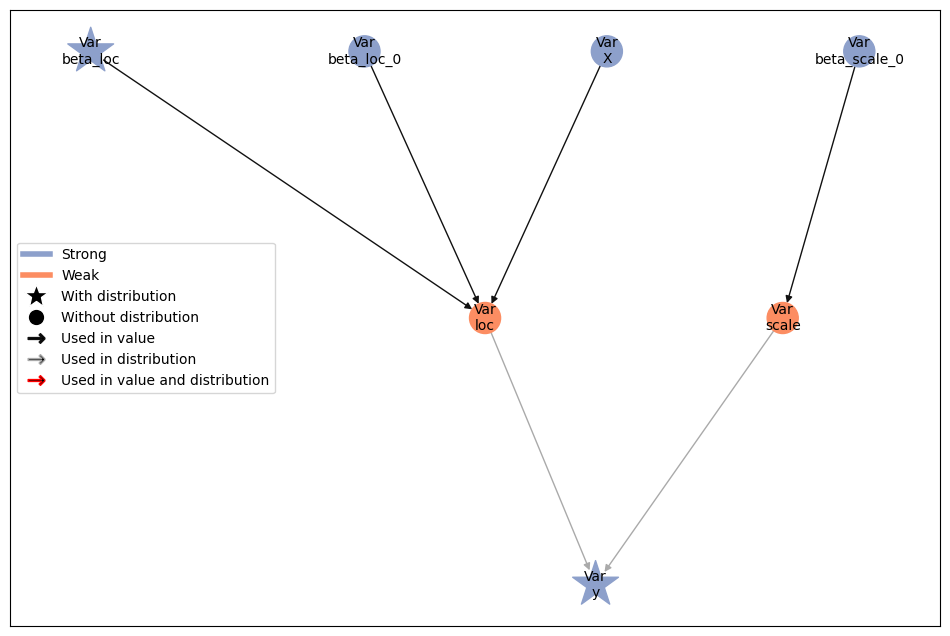

In [9]:
lsl.plot_vars(model=p, width=12, height=8)

In [10]:
res = (
    opt.QuickOptim(
        p,
        loss=opt.NegLogProbLoss(p, data),
        stopper=opt.Stopper(epochs=2000, patience=5),
        optimizers="lbfgs",
    )
    .build_engine()
    .fit()
)
p.state = p.update_state(res.best_position)

Training loss: 1434.191, Validation loss: 1434.191:   1%|▏         | 26/2000 [00:00<00:44, 43.98it/s]


Now we build the  variational distribution.
Here, we used two independent Gaussian distributions for the parameters.

In [11]:
q_beta_loc = opt.VDist(["beta_loc_0", "beta_loc"], p).mvn_diag(
    # jnp.zeros(Q), jnp.ones(Q)
)
q_beta_scale = opt.VDist(["beta_scale_0"], p).mvn_diag(
    # jnp.zeros(1), jnp.ones(1)
)
vi_dist = opt.CompositeVDist(q_beta_loc, q_beta_scale).build()
parameters = vi_dist.parameters

In [12]:
parameters

['(beta_scale_0)_scale_transformed',
 '(beta_scale_0)_loc',
 '(beta_loc_0|beta_loc)_scale_transformed',
 '(beta_loc_0|beta_loc)_loc']

Next, we initialize our loss object.

In [13]:
loss = opt.Elbo.from_vdist(vi_dist, data, nsamples=10, nsamples_validate=100)

Next, we initialize the optimizer.

In [14]:
optim = opt.Optimizer(parameters, optimizer=optax.adam(learning_rate=1e-3))

Next, we initialize the engine.

In [15]:
engine = opt.OptimEngine(
    loss=loss,
    batches=bi,
    split=data,
    optimizers=[optim],
    stopper=opt.Stopper(epochs=5000, patience=500, atol=0.0, rtol=1e-6),
    seed=42,
    initial_state=p.state,
    restore_best_position=True,
    prune_history=True,
    show_progress=True,
    save_position_history=True,
    progress_n_updates=100,
)

Finally, we run the optimization.

In [16]:
# with jax.disable_jit():
result = engine.fit()

Training loss: 1295.754, Validation loss: 1381.330:  15%|█▌        | 765/5000 [00:01<00:07, 554.68it/s]


Now we can inspect the loss and parameter history.

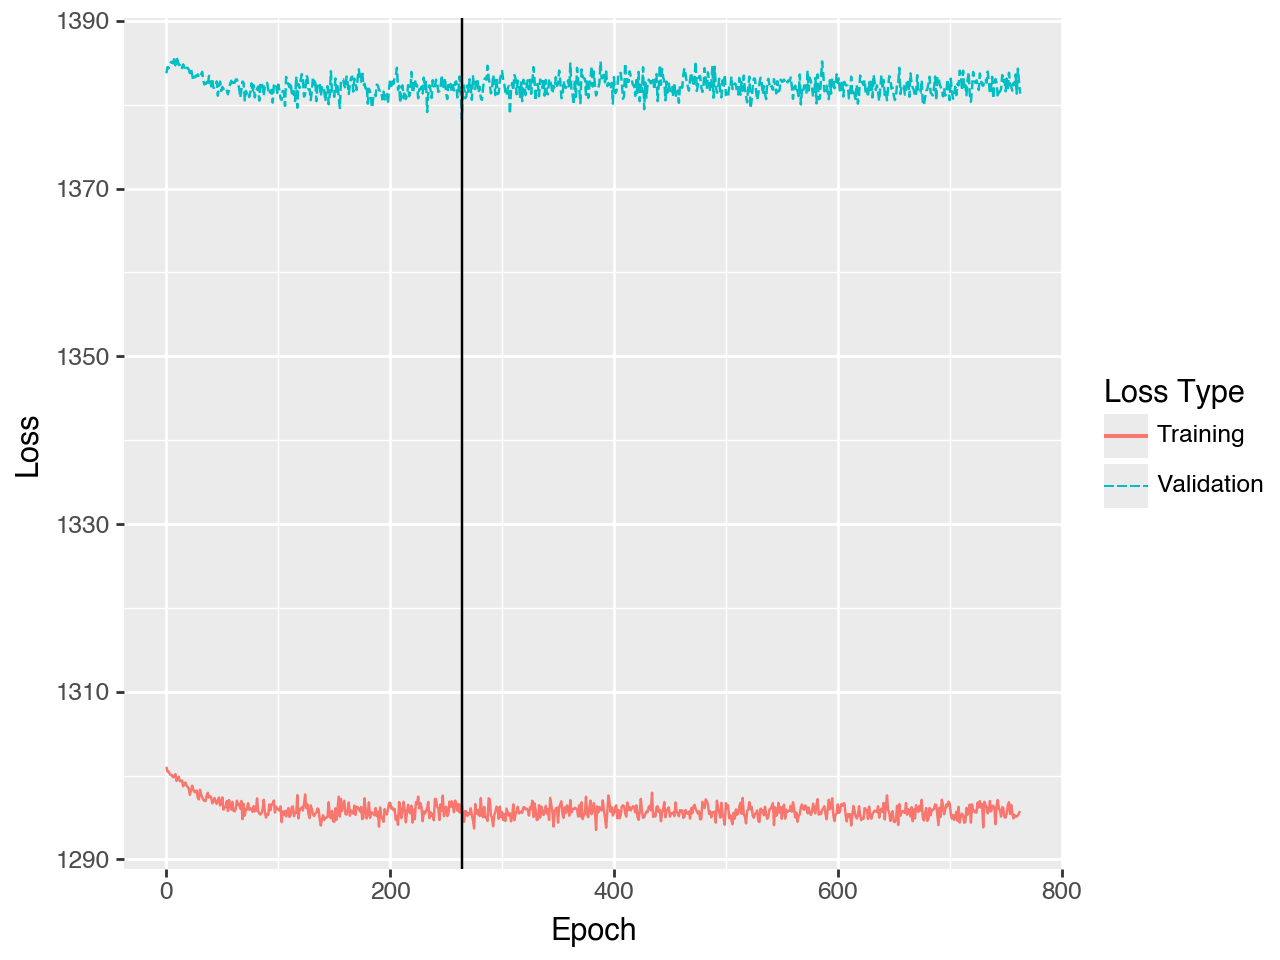

In [17]:
result.plot_loss()

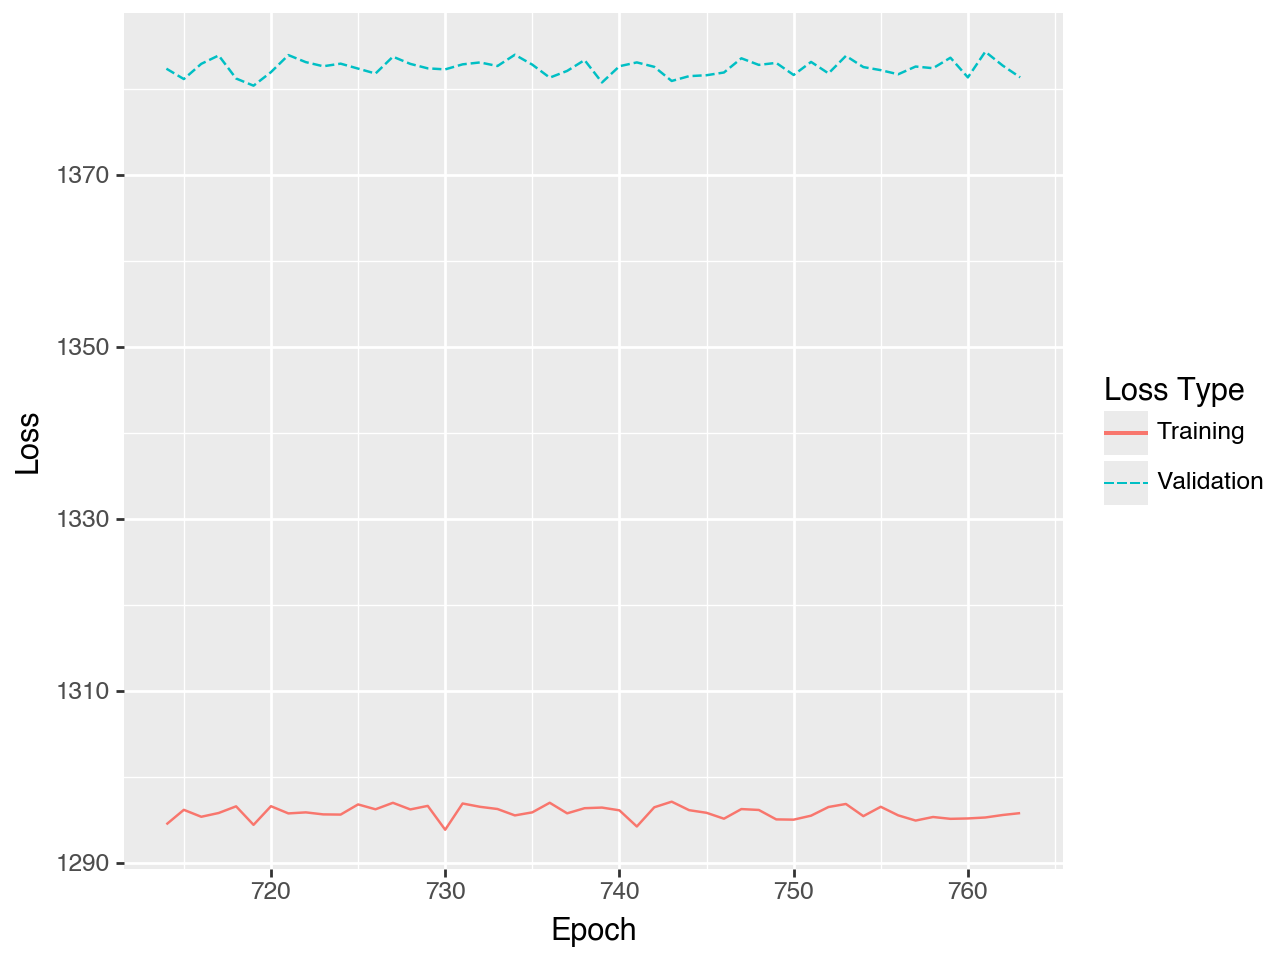

In [18]:
result.plot_loss(window=50)

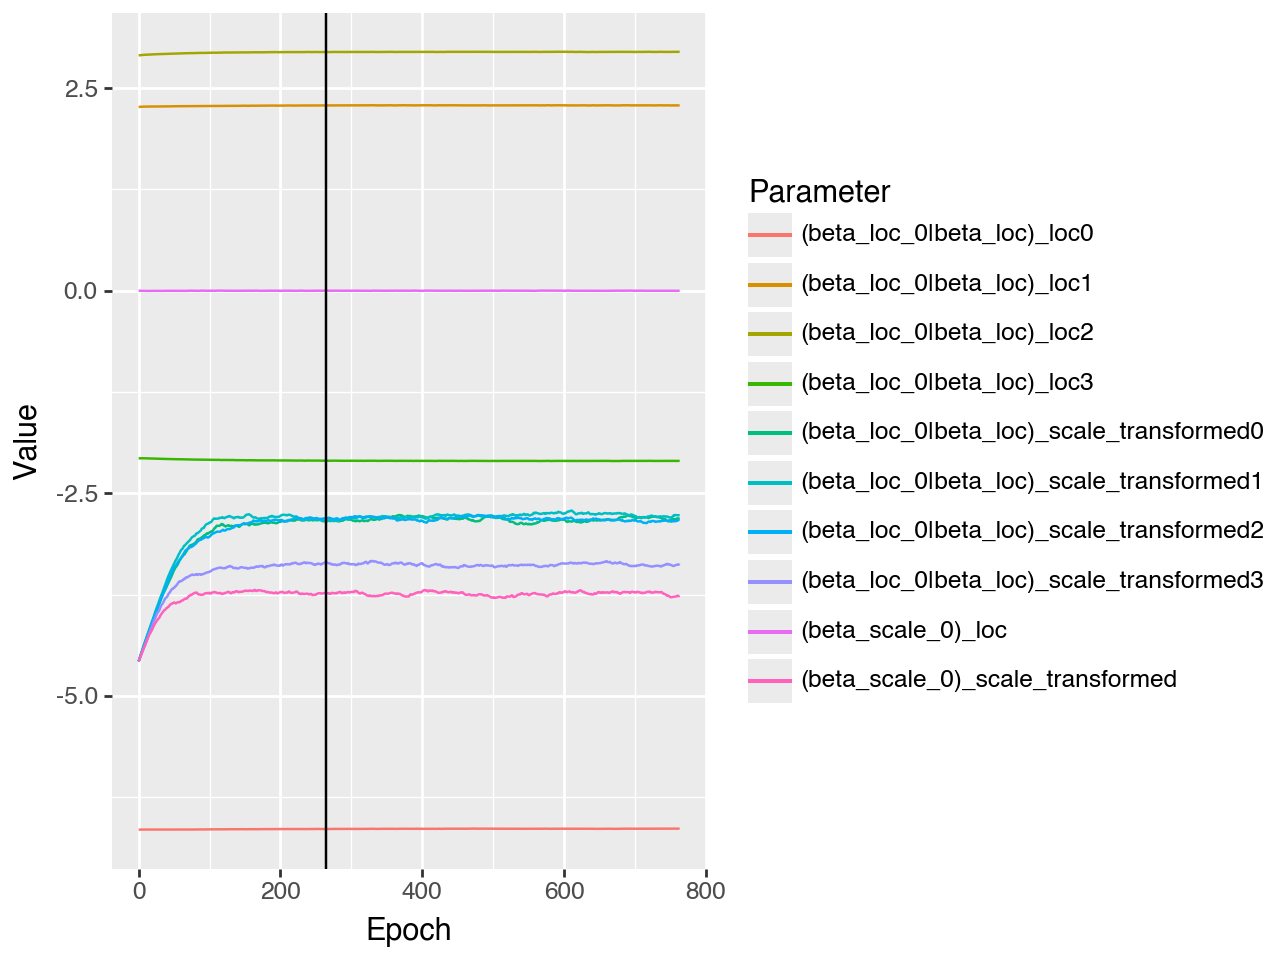

In [19]:
result.plot_params()

In [20]:
result.best_position["(beta_loc_0|beta_loc)_scale_transformed"]

Array([-2.841225 , -2.8437996, -2.8087697, -3.3546257], dtype=float32)

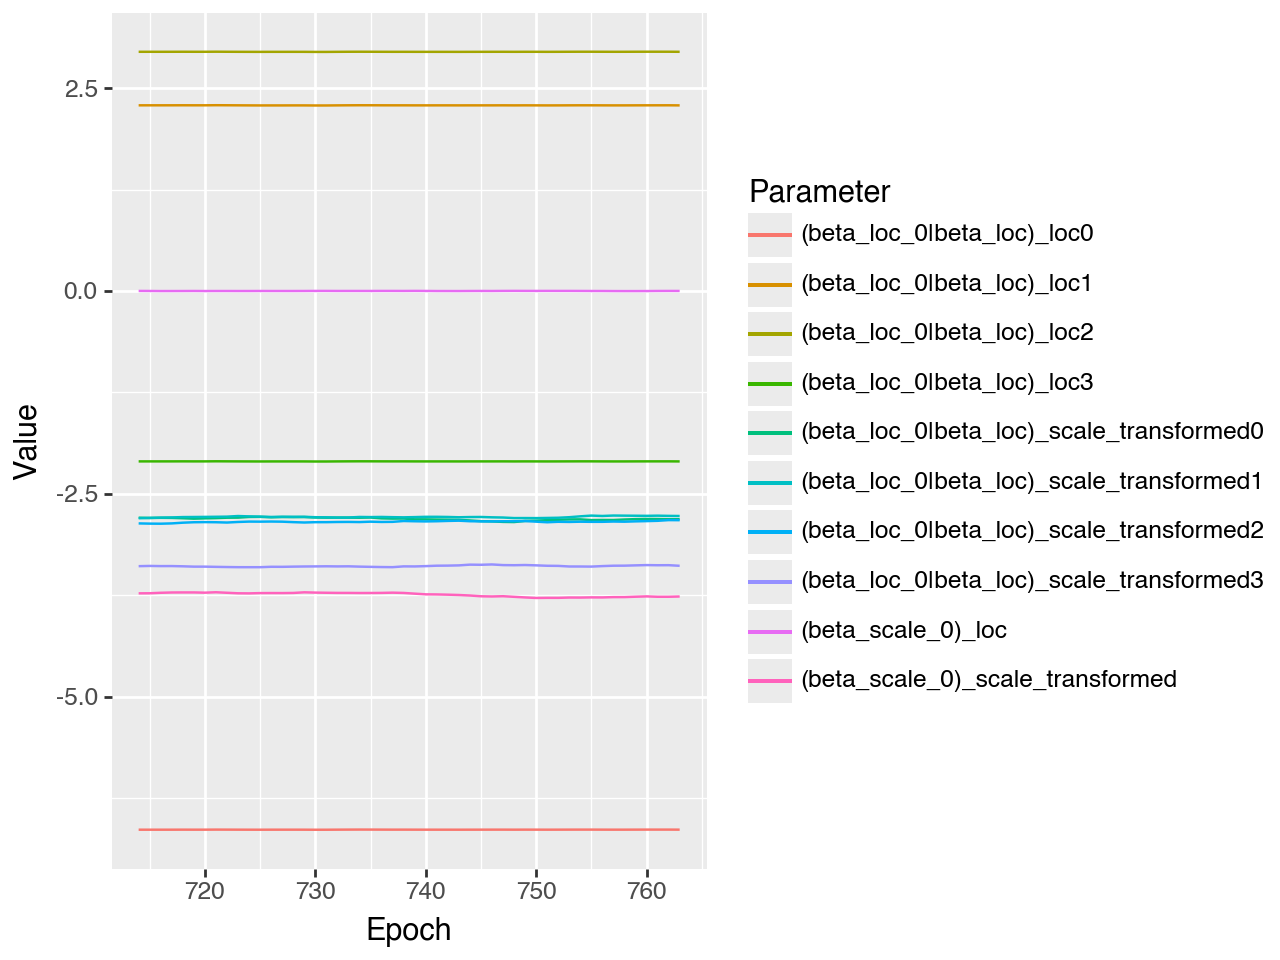

In [21]:
result.plot_params(window=50)

For VI, we can now sample from the variational distribution and translate these samples
into a form that is easily usable as an approximation to the posterior.
We can then use the existing goose functionality to summarize the samples, etc.

In [22]:
p_samples = vi_dist.sample_p(
    n=1000, seed=jax.random.key(42), prepend_axis=True, at_position=result.best_position
)

# add samples of the actual quantity of interest
s_samples = p.predict(p_samples, predict=["s"])
summary = gs.SamplesSummary(p_samples | s_samples)
summary.to_dataframe()

KeyError: 's'

In [ ]:
gs.plot_pairs(p_samples | s_samples)

## Variations

### One combined variational dist

In [ ]:
vi_dist = opt.VDist(["m", "s_transformed"], p).mvn_diag()

### Custom variational dist

In [ ]:
q1 = opt.VDist(["m"], p).mvn_diag()

dist_s_transformed = lsl.Dist(
    tfd.LogNormal,
    loc=lsl.Var.new_param(0.0, name="(s_transformed)_loc"),
    scale=lsl.Var.new_param(1.0, name="(s_transformed)_scale"),
)
dist_s_transformed["scale"].transform(tfb.Softplus())

# VDist.init takes any liesel distribution
q2 = opt.VDist(["s_transformed"], p).init(dist=dist_s_transformed)

vi_dist = opt.CompositeVDist(q1, q2).build()
parameters = vi_dist.parameters

### Blocked optimizers

In [ ]:
opt1 = opt.Optimizer(q1.parameters, optimizer=optax.adam(learning_rate=1e-2))
opt2 = opt.Optimizer(q2.parameters, optimizer=optax.adam(learning_rate=1e-5))
optimizers = [opt1, opt2]